In [148]:
import json
import folium
import datetime
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from geopandas.tools import sjoin
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

%matplotlib inline

## Drawing Maps

The following function draws a map following the provided boundaries. If a dataset is provided, it also shows the dataset value associated with each area in the map. Due to problems with Chrome, we save the map with the chosen filename, instead of visualizing it on the notebook.

In [149]:
def plot_map(geo_df, area_name="community", data=None, column_name="values", map_name="map.html"):
    m = folium.Map(location=[41.8755616, -87.6244212], tiles='Mapbox Bright', zoom_start=11) ## This location is Chicago
    
    if data is None:
        folium.GeoJson(
            geo_df,
            name='geojson'
        ).add_to(m)
    else:
        #bins = list(data.quantile(np.linspace(0, 1, 15))) ## to use bins, gotta check fill_color
        folium.Choropleth(
            geo_data=geo_df,
            name='choropleth',
            data=data,
            columns=[area_name, column_name],
            key_on='feature.properties.{}'.format(area_name),
            fill_color='YlGnBu',
            fill_opacity=0.7,
            line_opacity=0.2
            #bins=bins
        ).add_to(m)
        
    m.save("maps/" + map_name)

## Community Areas

This dataset was provided by the city of Chicago's government. It divides the city into community areas. Throughout our project, we use these community areas as neighborhoods about which we will present and study correlations between food quality and socio-economical variables.

In [150]:
geo_df = gpd.read_file("data/chicago_boundaries_community_area.geojson")
geo_df.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...


In [151]:
geo_df = geo_df[["community", "shape_area", "shape_len", "geometry"]]
len(geo_df)

77

In [152]:
plot_map(geo_df, "community", map_name="boundary.html")

## Assigning Coordinates to Community Area

We define the following functions in order to assign a coordinate (i.e., a food inspection location) to the community area in which it is located. If a point is not inside any community area (e.g., in the boundary), we assign it to the nearest one.

In [153]:
def get_nearest_neigh(point, geo_df):
    idx = geo_df.geometry.distance(point).idxmin()
    return geo_df.loc[idx, 'community']

## key: key that will be used to join
def assign_community(geo_df, data, latitude="latitude", longitude="longitude", verbose=False):
    geometry = [Point(x, y) for x, y in zip(data[longitude], data[latitude])]
    crs = {'init': 'epsg:4326'}
    data_to_join = gpd.GeoDataFrame(data, 
                                       crs=crs,
                                       geometry=geometry)
    points_to_neigh = sjoin(data_to_join, geo_df, how='left')
    
    neigh_not_found = points_to_neigh[pd.isna(points_to_neigh['community'])]
    
    if verbose:
        print("There are {} points without an exact neighborhood".format(len(neigh_not_found)))
    
    neigh_not_found['community'] = neigh_not_found.copy().geometry.apply(get_nearest_neigh, geo_df=geo_df)
    points_to_neigh.loc[neigh_not_found.index] = neigh_not_found
    
    if verbose:
        print("There are {} points without an exact neighborhood"\
              .format(len(points_to_neigh[pd.isna(points_to_neigh['community'])])))
    
    columns_to_return = list(data.columns) + ["community"]
    return points_to_neigh[columns_to_return]

## Census Data

In order to normalize our results and analyze food quality prejudice by color, we also obtained information of the latest census conducted in Chicago.

In [154]:
census = pd.read_csv("data/census.csv", header=1)
census.head()

,Community,Community Number,Total Population,Age 0‐2,Age 3‐4,Age 5,Age 6‐12,Families with a child under age 6,Percent Hispanic,Percent Non‐ Hispanic Black,Percent Non‐ Hispanic White,Percent Non‐ Hispanic Asian,Percent Non‐ Hispanic Other or Multiple Races,Children 0‐5,Children 6‐17,Children 0‐5.1,Children 6‐11,Children 0‐5.2,Children 6‐11.1,Unnamed: 19
0,Rogers Park,1.0,"53,470","2,164","1,166",616,"3,819","2,708",24%,24%,45%,5%,3%,63%,61%,29%,35%,46%,70%,NaN
1,West Ridge,2.0,"75,185","3,507","2,075","1,095","7,957","4,293",20%,13%,41%,21%,4%,55%,67%,34%,40%,54%,61%,NaN
2,Uptown,3.0,"54,001","1,647",884,370,"2,681","2,053",16%,19%,51%,11%,3%,72%,61%,24%,32%,40%,70%,NaN
3,Lincoln Square,4.0,"46,881","2,163",902,324,"2,380","2,380",18%,6%,62%,10%,4%,59%,72%,14%,21%,27%,31%,NaN
4,North Center,5.0,"35,406","2,043","1,076",636,"2,873","2,468",11%,9%,73%,4%,3%,73%,77%,5%,7%,8%,15%,NaN


In [155]:
columns_to_keep = ["Community", "Total Population", "Percent Hispanic", "Percent Non‐ Hispanic Black",
                   "Percent Non‐ Hispanic White", "Percent Non‐ Hispanic Asian",
                   "Percent Non‐ Hispanic Other or Multiple Races"]
census = census[columns_to_keep]
census.columns = ["community", "population", "hispanic", "black", "white", "asian", "other"]

census = census.drop(census.tail(1).index)

In [156]:
races = ["hispanic", "black", "white", "asian", "other"]
census[races] = census[races].apply(lambda x: x.str.replace("%", "").astype("int32"), axis=0)
census["population"] = census["population"].str.replace(",", "").astype("int32")
census["community"] = census["community"].str.upper()
census.head()

,community,population,hispanic,black,white,asian,other
0,ROGERS PARK,53470,24,24,45,5,3
1,WEST RIDGE,75185,20,13,41,21,4
2,UPTOWN,54001,16,19,51,11,3
3,LINCOLN SQUARE,46881,18,6,62,10,4
4,NORTH CENTER,35406,11,9,73,4,3


In [157]:
census.loc[census['community'] == "O'HARE", 'community'] = 'OHARE'

In [158]:
set(geo_df["community"]) == set(census["community"])

True

## Food Inspections in Chicago

The main dataset in our project contains information about food inspections in the city of Chicago from 2010 to the present. We use the results of food inspections as a proxy of food quality in a certain community.

We drop inspections from our dataset if:
* The inspection does not indicate a pass or a failure, since we cannot evaluate the food quality without this information.
* The inspection does not assign a risk to a inspections/establishment, since we cannot evaluate the food quality without this information.
* The inspection does not have a location (i.e., latitude and longitude) because we cannot assign it to a community.

In [159]:
inspections = pd.read_csv("data/food-inspections.csv")
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,2216009.0,Daycare Above and Under 2 Years,Risk 1 (High),1300 W 99TH ST,CHICAGO,IL,60643.0,...,Pass,NaN,41.714168,-87.655291,"{'longitude': '41.7141680989703', 'latitude': ...",NaN,NaN,NaN,NaN,NaN
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,2589655.0,Restaurant,Risk 1 (High),1767 N MILWAUKEE AVE,CHICAGO,IL,60647.0,...,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.913588,-87.682203,"{'longitude': '41.9135877900482', 'latitude': ...",NaN,NaN,NaN,NaN,NaN
2,2320328,LAS ASADAS MEXICAN GRILL,LAS ASADAS MEXICAN GRILL,2583309.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,Out of Business,NaN,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN
3,2320319,LA PALAPITA,LA PALAPITA,2694702.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2320228,47TH ST CANTINA,47TH ST CANTINA,2678250.0,Liquor,Risk 3 (Low),4311 W 47TH ST,CHICAGO,IL,60632.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.807662,-87.731480,"{'longitude': '41.80766199360051', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [160]:
columns_to_keep = ["Inspection ID", "DBA Name", "AKA Name", "Risk", "Results", "Latitude", "Longitude", "Violations", "Inspection Date"]
inspections = inspections[columns_to_keep]
inspections.columns = ["inspection_id", "dba_name", "aka_name", "risk", "results", "latitude", "longitude", "violations", "date"]
inspections.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'risk', 'results', 'latitude',
       'longitude', 'violations', 'date'],
      dtype='object')

In [161]:
def map_risk(x_):
    x = str(x_)
    if "High" in x:
        return 3
    elif "Medium" in x:
        return 2
    elif "Low" in x:
        return 1
    else:
        return x
    
def map_n_violations(x_):
    x = str(x_)
    return x.split(".")[0]
    
inspections["date"] = pd.to_datetime(inspections["date"])
inspections = inspections.dropna(subset=["latitude", "longitude"])
inspections = inspections[inspections["results"].isin(["Pass", "Pass w/ Conditions", "Fail"])]
inspections["risk"] = inspections["risk"].apply(map_risk)
inspections = inspections[inspections["risk"].isin([1, 2, 3])]
inspections["risk"] = inspections["risk"].astype("int16")
inspections["n_violations"] = inspections["violations"].fillna(0).apply(map_n_violations)
inspections["n_violations"] = inspections["n_violations"].astype("int32")
inspections.head()

,inspection_id,dba_name,aka_name,risk,results,latitude,longitude,violations,date,n_violations
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,3,Pass,41.714168,-87.655291,NaN,2019-10-23,0
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,3,Pass w/ Conditions,41.913588,-87.682203,23. PROPER DATE MARKING AND DISPOSITION - Comm...,2019-10-23,23
3,2320319,LA PALAPITA,LA PALAPITA,3,Pass,41.808025,-87.720037,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,2019-10-23,47
4,2320228,47TH ST CANTINA,47TH ST CANTINA,1,Pass w/ Conditions,41.807662,-87.731480,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2019-10-22,3
5,2320261,CRAZY BIRD,CRAZY BIRD,3,Pass w/ Conditions,41.891193,-87.657055,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,2019-10-22,16


In [162]:
inspections_community = assign_community(geo_df, inspections, verbose=True)
inspections_community.head()

There are 2665 points without an exact neighborhood
There are 0 points without an exact neighborhood


C:\Users\Gabriel\Miniconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,inspection_id,dba_name,aka_name,risk,results,latitude,longitude,violations,date,n_violations,geometry,community
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,3,Pass,41.714168,-87.655291,NaN,2019-10-23,0,POINT (-87.65529116028439 41.7141680989703),WASHINGTON HEIGHTS
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,3,Pass w/ Conditions,41.913588,-87.682203,23. PROPER DATE MARKING AND DISPOSITION - Comm...,2019-10-23,23,POINT (-87.6822028354253 41.9135877900482),WEST TOWN
3,2320319,LA PALAPITA,LA PALAPITA,3,Pass,41.808025,-87.720037,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,2019-10-23,47,POINT (-87.72003743037237 41.80802515275297),ARCHER HEIGHTS
4,2320228,47TH ST CANTINA,47TH ST CANTINA,1,Pass w/ Conditions,41.807662,-87.731480,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2019-10-22,3,POINT (-87.7314802731113 41.8076619936005),ARCHER HEIGHTS
5,2320261,CRAZY BIRD,CRAZY BIRD,3,Pass w/ Conditions,41.891193,-87.657055,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,2019-10-22,16,POINT (-87.65705497652716 41.89119348444125),WEST TOWN


SEPARATE BY YEAR LATER

The following maps show:
1. The log-number of inspections in each community per 100 citizens.
2. Rate of inspection failure by community.
3. A community's average risk of an establishment adversely affecting the public’s health in the range [0, 3], with three indicating a higher risk.
4. The average number of food inspection violations in each community per 100 citizens.
5. The number of inspections in each community normalized by number of establishments in our dataset.
6. The number of violations in each community normalized by number of establishments in our dataset.

In [163]:
population_community = census[["community", "population"]].set_index("community")["population"]
n_establishments = inspections_community.groupby("community")["dba_name"].nunique()

In [185]:
## 1) Number of inspections per 100 citizens
## We use log because... (gotta check if power law, but we need to use log or smth (log might not be the best))
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
n_inspections_per_capita = n_inspections.div(population_community) * 100
plot_map(geo_df, data=np.log(n_inspections_per_capita), map_name="n_inspections.html")

In [186]:
## 2) Rate of failure
neigh_results = inspections_community.groupby(["community", "results"]).count()["inspection_id"].rename("values")
percentage_results = (neigh_results.div(n_inspections) * 100).reset_index()
failure_community = percentage_results[percentage_results["results"]=="Fail"]
failure_community = failure_community.drop("results", axis="columns").set_index("community")["values"]
plot_map(geo_df, data=failure_community, map_name="rate_failure.html")

In [187]:
## 3) Average risk
average_risk = inspections_community.groupby("community").mean()["risk"].rename("values")
plot_map(geo_df, data=average_risk, map_name="average_risk.html")

In [188]:
## 4) Number of violations per capita (10000)
## We use log because... (gotta check if power law, but we need to use log or smth (log might not be the best))
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
average_violations_per_capita = average_violations.div(population_community) * 10000
plot_map(geo_df, data=np.log(average_violations_per_capita), map_name="average_n_violations.html")

In [189]:
## 5) # inspections / # establishments
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
norm_n_inspections = n_inspections.div(n_establishments)
plot_map(geo_df, data=norm_n_inspections, map_name="n_inspections_per_establish.html")

In [190]:
## 4) Number of violations / # establishments
## We use log because... (gotta check if power law, but we need to use log or smth (log might not be the best))
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
norm_average_violations = average_violations.div(n_establishments)
plot_map(geo_df, data=np.log(norm_average_violations), map_name="average_n_violations_per_establish.html")

## Hardship Index

The city of Chicago also makes available the economic hardship of all its community areas. The economic hardship index is a function of:

1. Unemployment (over the age of 16 years),
2. Education (over 25 years of age without a high school
diploma)
3. Per capita income level
4. Poverty (below the federal poverty level)
5. Crowded housing (housing units with more than one person
per room)
6. Dependency (population under 18 or over 64 years of age)

We will use the economic hardship index as a measurement of economic conditions of each community area in Chicago. A higher index indicates poorer conditions. For more information on the index: https://greatcities.uic.edu/wp-content/uploads/2016/07/GCI-Hardship-Index-Fact-SheetV2.pdf

In [170]:
income_df = pd.read_csv("data/Per_Capita_Income.csv")
income_df.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [171]:
income_df.columns = ['community_number','community','percentage_housing_crowded','percent_households_below_poverty','percent_aged_16+_unemployed','percent_aged_25+_without_highschool_diploma','percent_aged_under_18_or_over_64','per_capita_income','hardship_index']
income_df["community"].unique

<bound method Series.unique of 0         Rogers Park
1          West Ridge
2              Uptown
3      Lincoln Square
4        North Center
           ...       
73    Mount Greenwood
74        Morgan Park
75             O'Hare
76          Edgewater
77            CHICAGO
Name: community, Length: 78, dtype: object>

In [172]:
income_df = income_df[income_df["community"] != 'CHICAGO']
income_df["community"] = income_df["community"].str.upper()

In [173]:
set(geo_df["community"]) == set(income_df["community"])

False

In [174]:
set(geo_df["community"]) - set(income_df["community"])

{'MONTCLARE', 'OHARE', 'WASHINGTON HEIGHTS'}

In [175]:
set(income_df["community"]) - set(geo_df["community"])

{'MONTCLAIRE', "O'HARE", 'WASHINGTON HEIGHT'}

In [176]:
income_df.loc[income_df['community'] == "O'HARE", 'community'] = 'OHARE'
income_df.loc[income_df['community'] == "MONTCLAIRE", 'community'] = 'MONTCLARE'
income_df.loc[income_df['community'] == "WASHINGTON HEIGHT", 'community'] = 'WASHINGTON HEIGHTS'
set(geo_df["community"]) == set(income_df["community"])

True

We normalize hardship into a [0, 1] range for our analysis. Since hardship is not a concept easy to understand as it is a function of many economic variables, we believe that comparing between communities will be easier after normalizing the index.

In [177]:
delta_hardship = income_df["hardship_index"].max() - income_df["hardship_index"].min()
income_df["hardship_index"] = income_df["hardship_index"]/delta_hardship

In [178]:
hardship = income_df[["community", "hardship_index"]].set_index("community").rename(columns={"hardship_index": "values"})["values"]
plot_map(geo_df, data=hardship, map_name="hardship.html")

# Hypotheses

### 1) Correlation Between Race and Food Quality

Explain hypothesis here

In [191]:
def plot_correlation_food_variables(food_quality_index=None, index_name="",
                                    variables_df=None, variables=None, variable_name="", method="pearson"):
    correlations = []
    for var in variables:
        var_community = variables_df[["community", var]].set_index("community")[var]
        correlations.append(var_community.corr(food_quality_index, method=method))
    plt.bar(x=variables, height=correlations)
    plt.title("Correlation between {} and {}".format(variable_name, index_name))

In [192]:
def scatter_plot_with_line(food_quality_index=None, index_name="",
                           variable_df=None, variable_name="", method="pearson"):
    plt.ylabel(index_name)
    plt.xlabel(variable_name)
    plt.scatter(variable_df, food_quality_index)

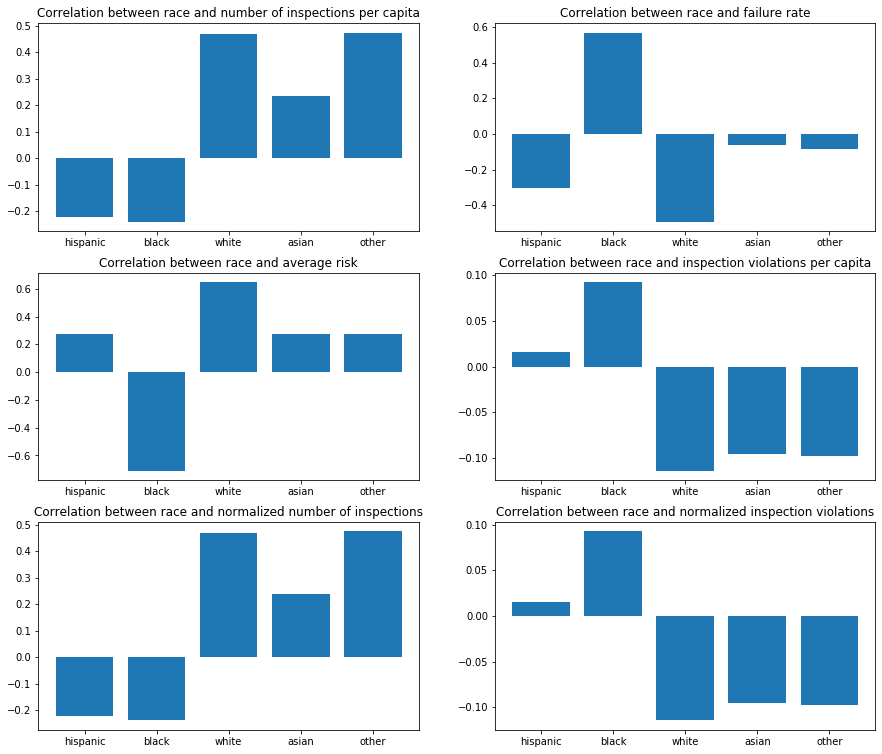

In [193]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita
plt.subplot(3, 2, 1)
plot_correlation_food_variables(norm_n_inspections, index_name="number of inspections per capita",
                                variables_df=census, variables=races, variable_name="race")

## 2) Rate of failure
plt.subplot(3, 2, 2)
plot_correlation_food_variables(failure_community, index_name="failure rate",
                                variables_df=census, variables=races, variable_name="race")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
plot_correlation_food_variables(average_risk, index_name="average risk",
                                variables_df=census, variables=races, variable_name="race")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
plot_correlation_food_variables(norm_average_violations, index_name="inspection violations per capita",
                                variables_df=census, variables=races, variable_name="race")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
plot_correlation_food_variables(norm_n_inspections, index_name="normalized number of inspections",
                                variables_df=census, variables=races, variable_name="race")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
plot_correlation_food_variables(norm_average_violations, index_name="normalized inspection violations",
                                variables_df=census, variables=races, variable_name="race")

Apparently, the black population lived in community areas with lower quality of food, a higher number of inspection violations and a lower number of inspections.

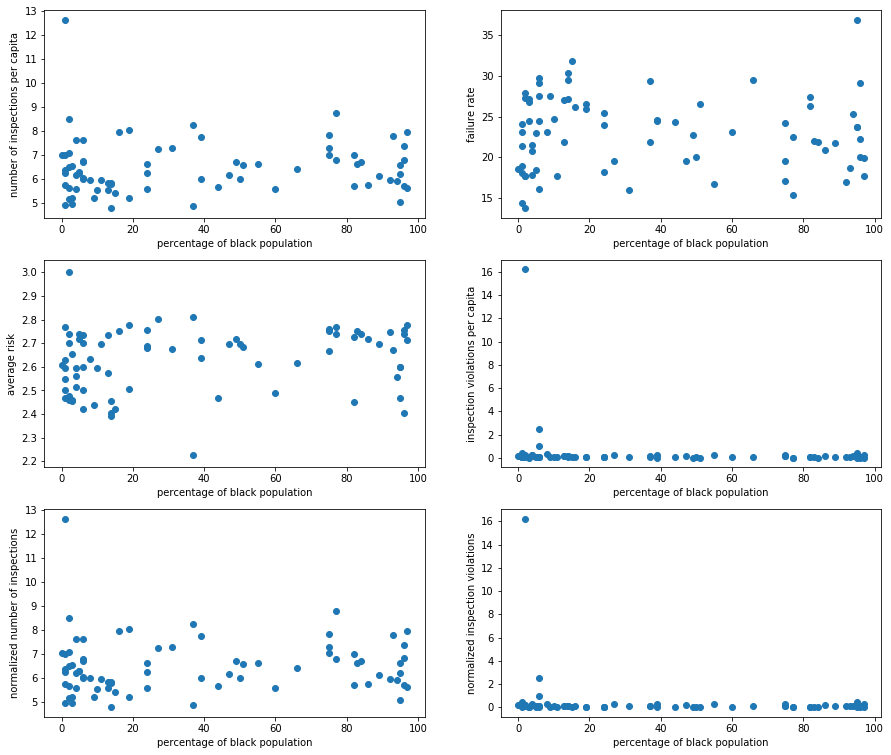

In [194]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita

plt.subplot(3, 2, 1)
scatter_plot_with_line(norm_n_inspections, index_name="number of inspections per capita",
                                variable_df=census["black"], variable_name="percentage of black population")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot_with_line(failure_community, index_name="failure rate",
                                variable_df=census["black"], variable_name="percentage of black population")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
scatter_plot_with_line(average_risk, index_name="average risk",
                                variable_df=census["black"], variable_name="percentage of black population")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot_with_line(norm_average_violations, index_name="inspection violations per capita",
                                variable_df=census["black"], variable_name="percentage of black population")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot_with_line(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=census["black"], variable_name="percentage of black population")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot_with_line(norm_average_violations, index_name="normalized inspection violations",
                                variable_df=census["black"], variable_name="percentage of black population")

# Does it really follow what we are expecting? I think we really need to run pairwise significance tests because these scatter plots are not nice.

In [53]:
census = census.set_index("community")
census["failure_rate"] = norm_n_inspections
census["dominant_race"] = census[races].idxmax(axis=1)
census.head()

,population,hispanic,black,white,asian,other,failure_rate,dominant_race
community,,,,,,,,
ROGERS PARK,53470,24,24,45,5,3,6.626424,white
WEST RIDGE,75185,20,13,41,21,4,6.595122,white
UPTOWN,54001,16,19,51,11,3,6.990000,white
LINCOLN SQUARE,46881,18,6,62,10,4,6.639810,white
NORTH CENTER,35406,11,9,73,4,3,6.240223,white


In [331]:
## If we get only the dominant race in the neighborhood, only asian-black is siginificant.
print(pairwise_tukeyhsd(census["failure_rate"], census["dominant_race"]))

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower    upper  reject
---------------------------------------------------------
   asian    black  -9.6851 0.0482 -19.3156 -0.0546   True
   asian hispanic   -9.605 0.0557 -19.3735  0.1634  False
   asian    white  -6.7008 0.2769 -16.4322  3.0307  False
   black hispanic   0.0801    0.9  -3.6507  3.8108  False
   black    white   2.9843 0.1443  -0.6485  6.6171  False
hispanic    white   2.9042 0.2303  -1.0799  6.8884  False
---------------------------------------------------------


In [334]:
## This doesnt' work for us -> fuck it
results = ols("failure_rate ~ white + black + asian + hispanic + other", data=census).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           failure_rate   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     3.912
Date:                Wed, 13 Nov 2019   Prob (F-statistic):            0.00345
Time:                        22:12:48   Log-Likelihood:                -227.68
No. Observations:                  77   AIC:                             467.4
Df Residuals:                      71   BIC:                             481.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0804     85.998      0.094      0.925    -163.395     179.556
white         -0.0278      0.867     -0.032      0.975      -1.757       1.701
black         -0.0449      0.861     -0.052      0.959      -1.761       1.672
asian          0.1703      0.863      0.197      0.844      -1.551       1.892
hispanic      -0.0589      0.859     -0.069      0.946      -1.771       1.654
other          0.6265      0.983      0.638      0.526      -1.333       2.586
==============================================================================
Omnibus:                       84.953   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              921.032
Skew:                           3.374   Prob(JB):                    1.00e-200
Kurtosis:                      18.542   Cond. No.                     8.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## What we need is a pairwise comparison between correlation coefficients and I dont know how to do it. Niko?

### 2) Correlation Between Hardship and Food Quality

Explain hypothesis here

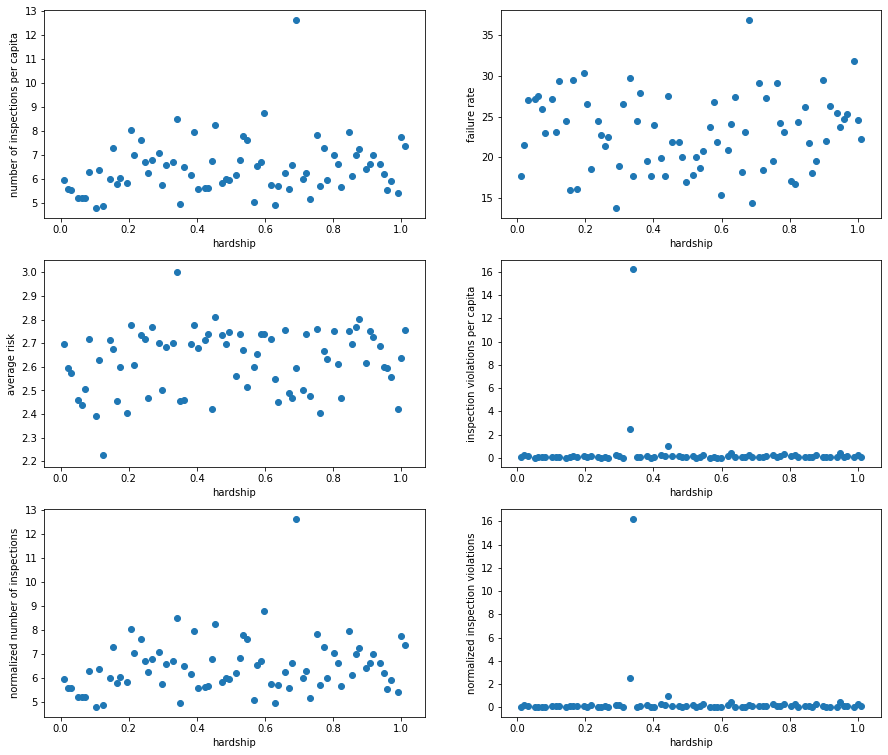

In [195]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita


plt.subplot(3, 2, 1)
scatter_plot_with_line(norm_n_inspections, index_name="number of inspections per capita",
                                variable_df=hardship, variable_name="hardship")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot_with_line(failure_community, index_name="failure rate",
                                variable_df=hardship, variable_name="hardship")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
scatter_plot_with_line(average_risk, index_name="average risk",
                                variable_df=hardship, variable_name="hardship")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot_with_line(norm_average_violations, index_name="inspection violations per capita",
                                variable_df=hardship, variable_name="hardship")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot_with_line(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=hardship, variable_name="hardship")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot_with_line(norm_average_violations, index_name="normalized inspection violations",
                                variable_df=hardship, variable_name="hardship")